# Library imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Data Loading and Preprocessing

Analysing & preprocessing imported data...

Number of time series: 269
Number of 1 hour time steps: 673

Dropping time series with more than 80.0% absent values.

Dropping time series with only zero values: [25, 133, 169]
Number of time series after drop: 195

Checking dataframe with 673 ticks.
Time steps with less than 95% valid values: [233]


3           5           6           9           10          11   \
count  673.000000  673.000000  673.000000  673.000000  673.000000  670.000000   
mean     0.205093    0.189064    0.048025    0.022624    0.020566    0.002520   
std      0.127571    0.123518    0.024994    0.014217    0.011992    0.001796   
min      0.024700    0.013800    0.003300    0.000000    0.002200   -0.004518   
25%      0.099700    0.094100    0.026600    0.010800    0.010500    0.001100   
50%      0.196100    0.155200    0.050000    0.020500    0.019400    0.002500   
75%      0.281600    0.284900    0.066300    0.032500    0.028000    0.003600   
max      0.985500    0.517700    0.126300    0.076600    0.055800    0.008600   

              12          15          16          18   ...         252  \
count  673.000000  673.000000  673.000000  673.000000  ...  673.000000   
mean     0.026205    0.976137    0.004904    0.016093  ...    0.252527   
std      0.014470    0.480758    0.002964    0.009622  ...    0.138321   
min      0.000000    0.186900   -0.000375    0.000500  ...    0.031600   
25%      0.013000    0.520200    0.002200    0.007200  ...    0.124700   
50%      0.026600    1.047200    0.005000    0.016300  ...    0.265800   
75%      0.037500    1.333300    0.006900    0.023600  ...    0.348800   
max      0.068600    2.510800    0.015800    0.044400  ...    0.662200   

              255         256         257         258         259         264  \
count  673.000000  673.000000  673.000000  673.000000  673.000000  669.000000   
mean     0.005146    0.918033    0.009734    0.007344    0.010898    0.006282   
std      0.003142    0.515342    0.005064    0.004730    0.006676    0.006030   
min      0.000000    0.111600    0.001117   -0.001083    0.000800   -0.010190   
25%      0.002500    0.490800    0.005800    0.003600    0.005800    0.002200   
50%      0.005200    0.888300    0.009100    0.006600    0.009400    0.005000   
75%      0.007500    1.280500    0.012700    0.010200    0.014400    0.008800   
max      0.016100    2.290800    0.028300    0.024400    0.035000    0.040000   

              265         266         268  
count  673.000000  673.000000  673.000000  
mean     0.086448    0.002419    0.003302  
std      0.055594    0.002163    0.002038  
min      0.006900    0.000000   -0.000318  
25%      0.032500    0.000500    0.001600  
50%      0.084700    0.001900    0.003300  
75%      0.125200    0.003800    0.004700  
max      0.215000    0.010800    0.009400  

[8 rows x 195 columns]

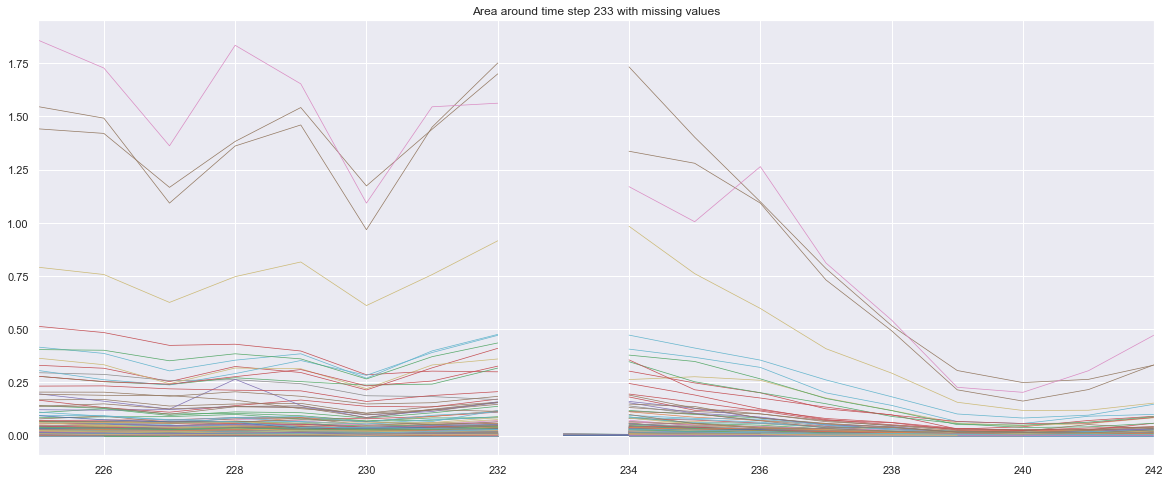

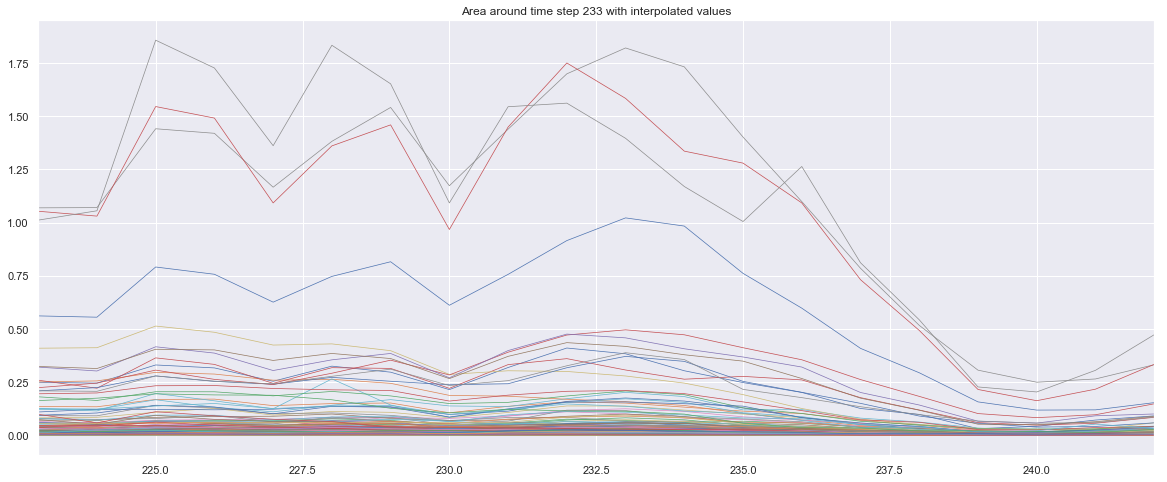

In [2]:
df_raw = pd.read_csv("metrics.csv", header=None, dtype=np.float, na_values=-1.0).transpose()
print("Analysing & preprocessing imported data...\n")
print("Number of time series: " + str(df_raw.columns.size))
print("Number of 1 hour time steps: " + str(df_raw.index.size))
thresh_percent = 0.80
thresh_num = int(df_raw.index.size * thresh_percent)

print("\nDropping time series with more than " + str(thresh_percent * 100) + "% " + "absent values.")
df = df_raw.dropna(axis='columns', thresh=thresh_num)


zeros = []
for col in df:
    if(df[col].sum() == 0):
        zeros.append(col)
        df = df.drop(columns=col)
print("\nDropping time series with only zero values: " + str(zeros))
print("Number of time series after drop: " + str(df.columns.size))

# interpolate time-series with missing values using cubic splines
def get_na_ticks(dframe):
    na_rows = []
    print("\nChecking dataframe with " + str(df_raw.index.size) + " ticks.")
    for index, row in dframe.iterrows():
        if(row.count() < (0.05 * dframe.index.size)): na_rows.append(index)
    print("Time steps with less than 95% valid values: " + str(na_rows))
    return na_rows

na_rows = get_na_ticks(df)
df = df.interpolate(method='cubic')

for row in na_rows:
    title_str = "Area around time step " + str(row) + " with "
    df_raw.iloc[row-8:row+10].plot(linewidth=0.7, title=title_str + "missing values", legend=None,figsize=(20,8))
    df.iloc[row-10:row+10].plot(linewidth=0.7, title=title_str + "interpolated values", legend=None,figsize=(20,8))

df.describe()

<h3>Initial plot af all time series</h3>

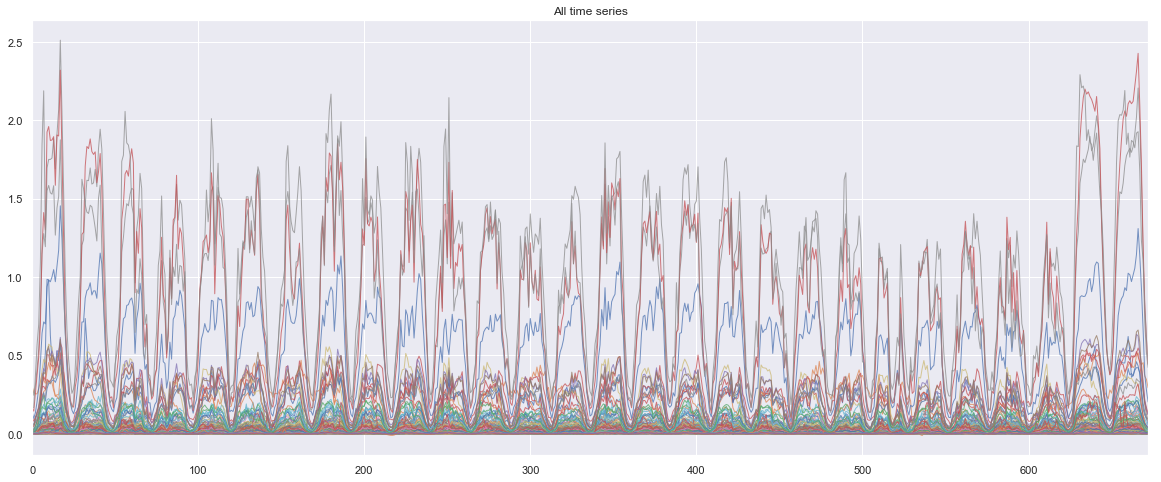

In [3]:
df.plot(linewidth=1, alpha=0.75, legend=None, figsize=(20,8), title="All time series")

<h5>The initial plot reveals a daily periodicity that can be highlighted marking 24 hour steps in the given data.</h5>

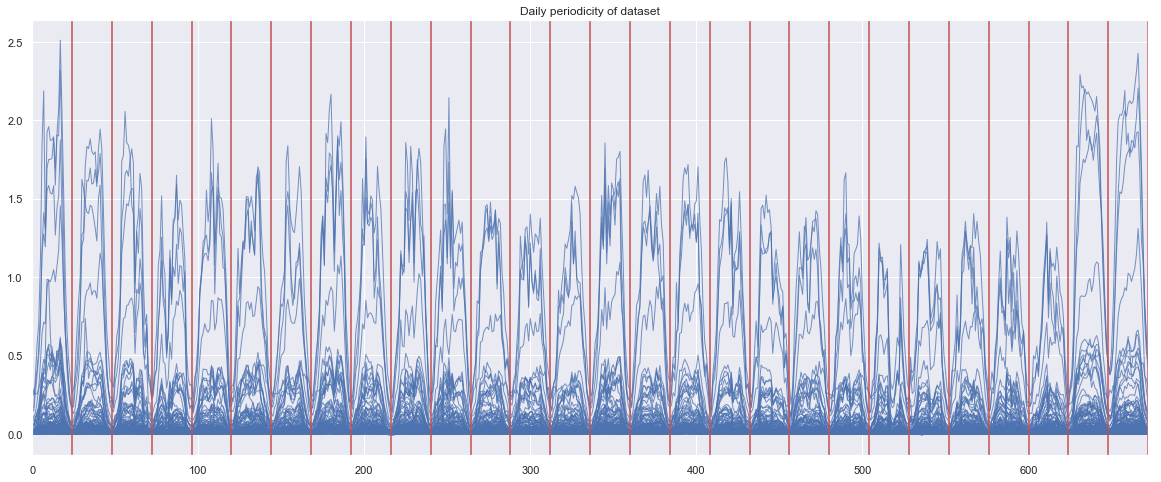

In [4]:
df.plot(linewidth=1, alpha=0.75, legend=None, figsize=(20,8), title="Daily periodicity of dataset", c='b')
for step in range(df.index.size):
    if(step%24==0): plt.axvline(x=step, c='r')

<h5>A first look at the plot leads to the assumption of 3 main groups based on the amplitude for the given time series:<h5>
   <list>
       <li>high peaks above 1.0</li> 
       <li>medium peaks between 0.25 and 0.75</li>  
       <li>low peaks beneath 0.25</li>
       <li>time series that take negative values</li>
      </list>
<h5>We use these values for an initial broad grouping. The time series might still belong to a cluster with other peaks, the now filtered time series will be fitted into clusters at the end of the analysis.</h5>

Number of time series with high peaks: 4
Number of time series with medium peaks: 13
Number of time series with low peaks: 124


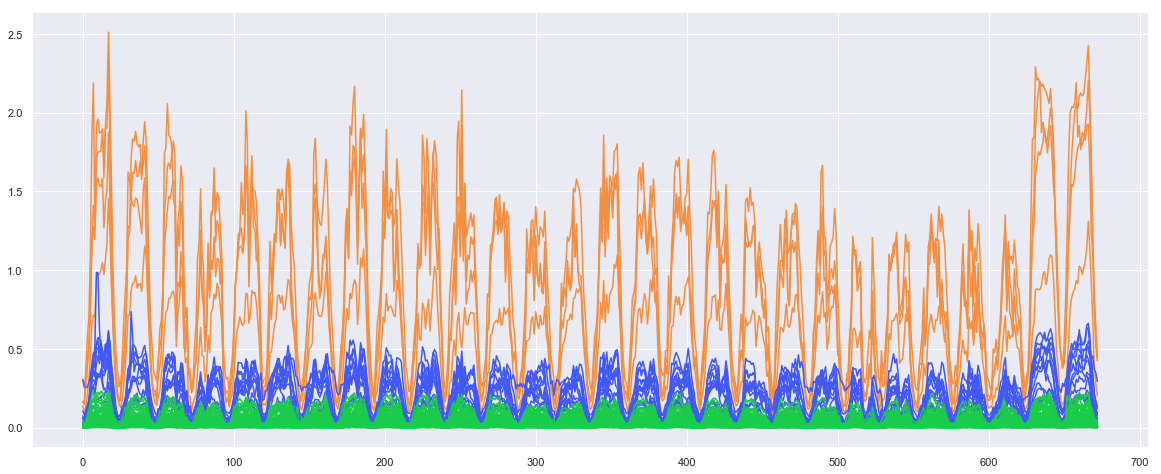

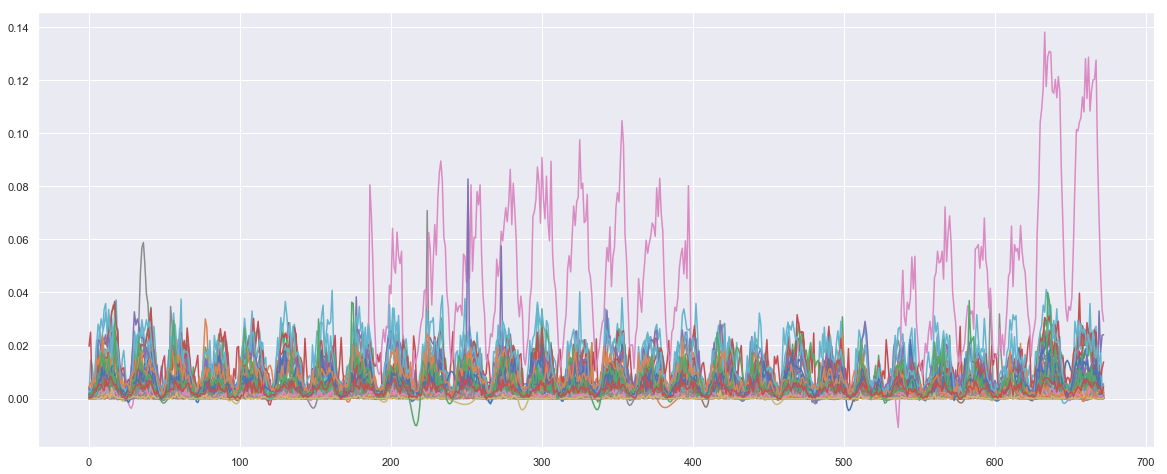

In [5]:
# Filtering high, medium and low peak time series
h = []
m = []
l = []
n = []

for col in df:
    if(df[col].min() < 0.0): n.append(col)
    elif(df[col].max() > 1.0): h.append(col)
    elif(df[col].max() > 0.25): m.append(col)
    else: l.append(col)
print("Number of time series with high peaks: " + str(len(h)))      
print("Number of time series with medium peaks: " + str(len(m)))  
print("Number of time series with low peaks: " + str(len(l)))  
fig, ax = plt.subplots(figsize=(20,8))
ax.set_label("Grouping of time series by peaks")
plt.plot(df[h], c='#f48f42')
plt.plot(df[m], c='#4158f4')
plt.plot(df[l], c='#1acc49')
plt.show()
fig, ax = plt.subplots(figsize=(20,8))
ax.set_label("Grouping of time series that take negative values")
plt.plot(df[n])
plt.show()
plt.close()

<h1>Filtering with normalization, offset and rolling mean</h1>

<h5>Since most of the given time series have low peaks, we focus on analysis of the low-mean group. To find correlations in this group, we normalize the data and due to the periodicity, we can apply a rolling mean with a window of 24 hours. After applying the rolling mean we try to group correlating time series by using a vertical offset in the magnitude of the mean</h5>

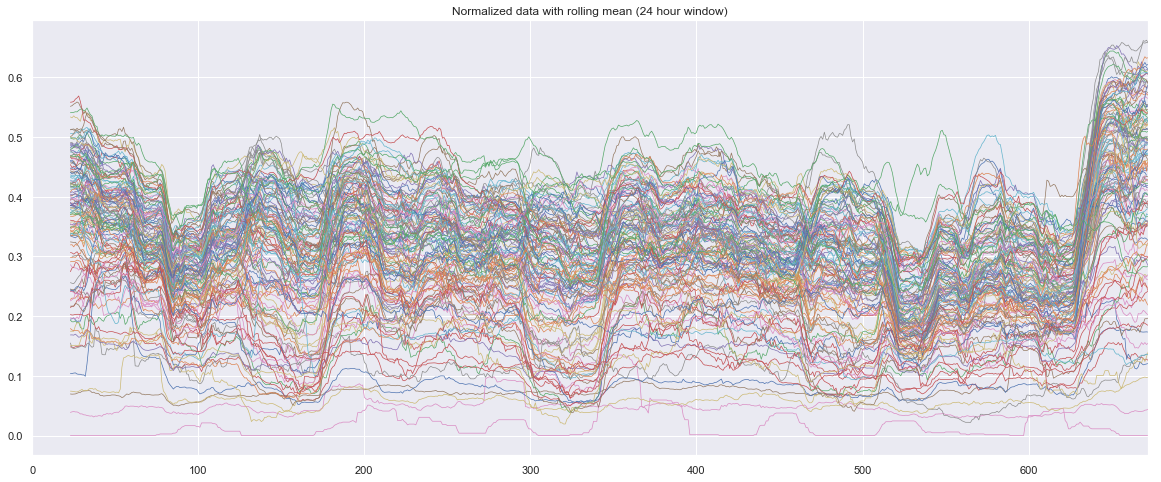

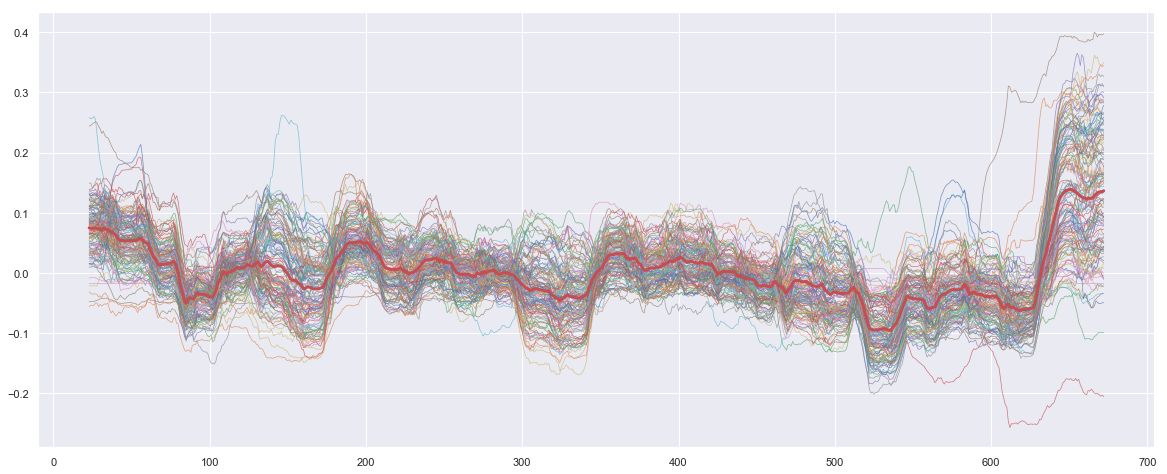

In [6]:
# Normalize time series of high correlating data
from sklearn.preprocessing import MinMaxScaler
def normalize_dframe(dframe):
    df_norm = pd.DataFrame()
    for col in dframe:
        # prepare data for normalization
        values = df[col].values
        values = values.reshape((len(values), 1))
        # train the normalization
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = scaler.fit(values)
        normalized = scaler.transform(values)
        df_norm[col]= normalized.flatten()
    return df_norm

def rollmean_dframe(dframe, window):
    return dframe.rolling(window=window).mean()

def apply_offset_mean(dframe):
    offset_vert = pd.DataFrame()
    for col in dframe:
        offset_vert[col] = dframe[col] - dframe[col].mean()    
    return offset_vert

def get_mean_series(dframe):
    means = []
    for row in dframe.index:
        means.append(dframe.iloc[row].mean())
    return pd.Series(data=means)

df_norm = normalize_dframe(df[l])
rolled = rollmean_dframe(df_norm, 24)
rolled_offset = apply_offset_mean(rolled)
mean_line = get_mean_series(rolled_offset)
rolled.plot(linewidth=0.7, legend=None, figsize=(20,8), title="Normalized data with rolling mean (24 hour window)")
plt.figure(figsize=(20,8))
plt.plot(rolled_offset,linewidth=0.7, alpha=0.75)
plt.plot(mean_line, linewidth=3, c='r')
plt.show()

<h5>The generated plot reveals that the data contains a large correlating group following the highlighted mean line. All outliers that have a high distance to this mean line will be sorted out in the following step.</h5>

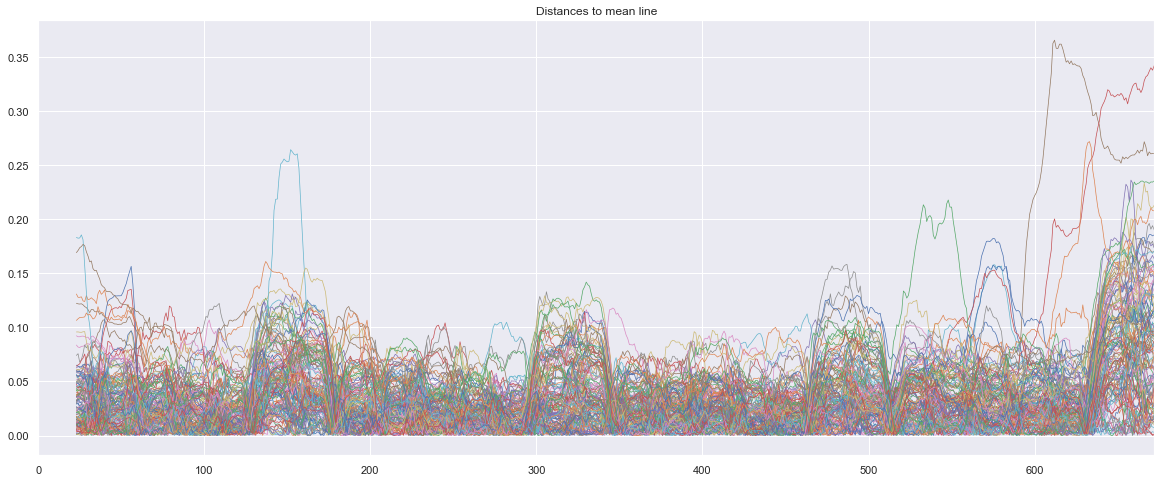

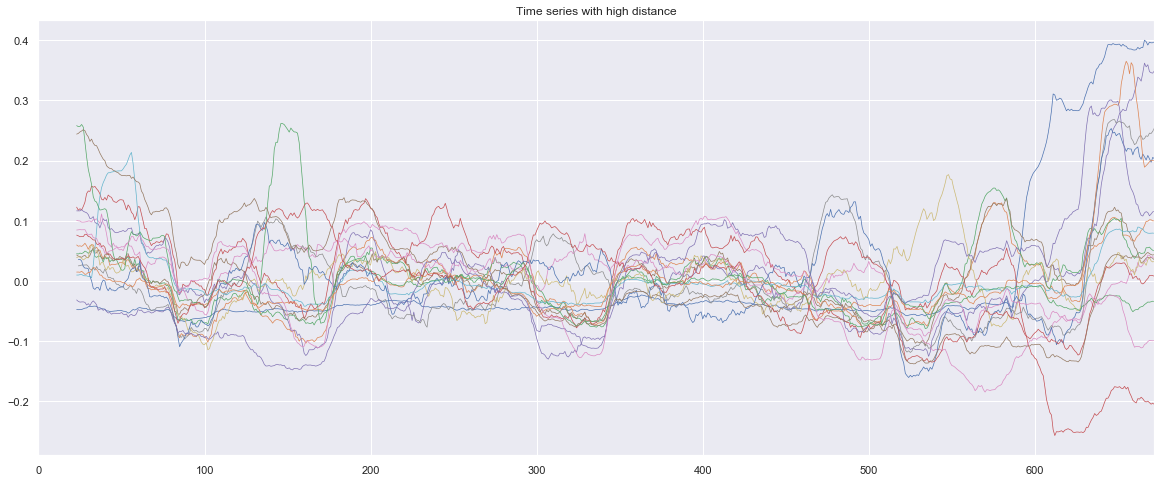

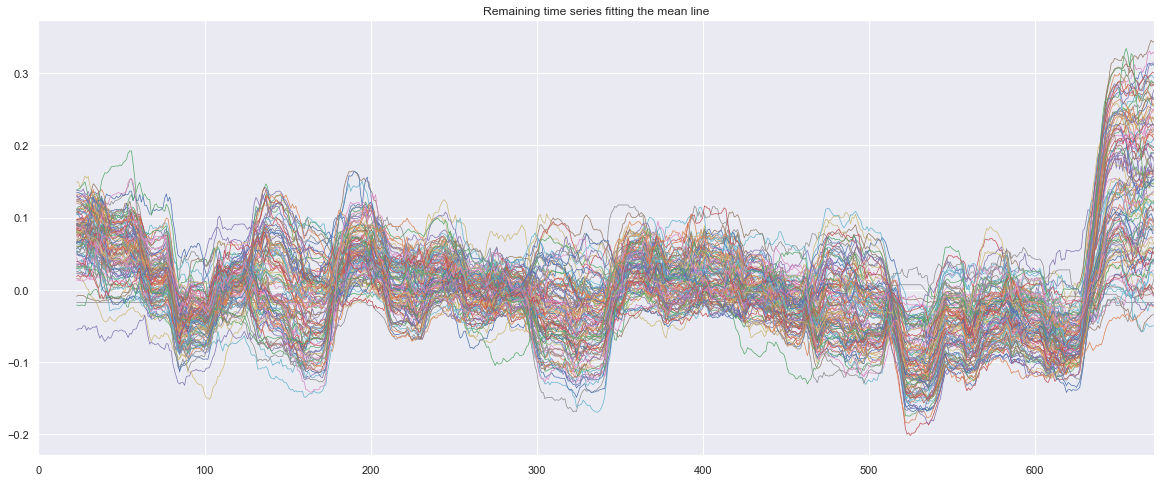

In [7]:
def calc_dist_to_series(dframe, series):
    distances = pd.DataFrame()
    for col in dframe:
        distances[col] = (dframe[col] - series)
    return distances.abs()

distances = calc_dist_to_series(rolled_offset, mean_line)
distances.plot(linewidth=0.7, legend=None, figsize=(20,8), title="Distances to mean line")

high_dist = []
ts_first = distances.iloc[:625]
ts_last = distances.iloc[625:]
for col in distances:
    if(ts_first[col].max()>0.15): high_dist.append(col)
    elif(ts_last[col].max()>0.22): high_dist.append(col)
        
rest = [x for x in distances.columns if x not in high_dist]
rolled_offset[high_dist].plot(linewidth=0.7, legend=None, figsize=(20,8), title="Time series with high distance")
rolled_offset[rest].plot(linewidth=0.7, legend=None, figsize=(20,8), title="Remaining time series fitting the mean line")

In [8]:
# Summarizing current results
groups = {
    'high': (h + m), 
    'outliers': (high_dist + n),  
    'main': (rest),  
}

<h5>We now go back to the initial dataset without normalization and rolling mean and try to filter out the remaining outliers using a correlation matrix. </h5>

<h1>Correlation of mean-filtered groups</h1>

Since this is just a broad filtering, a look at the correlation between the time series inside the groups can show us how good the mean filtering was.

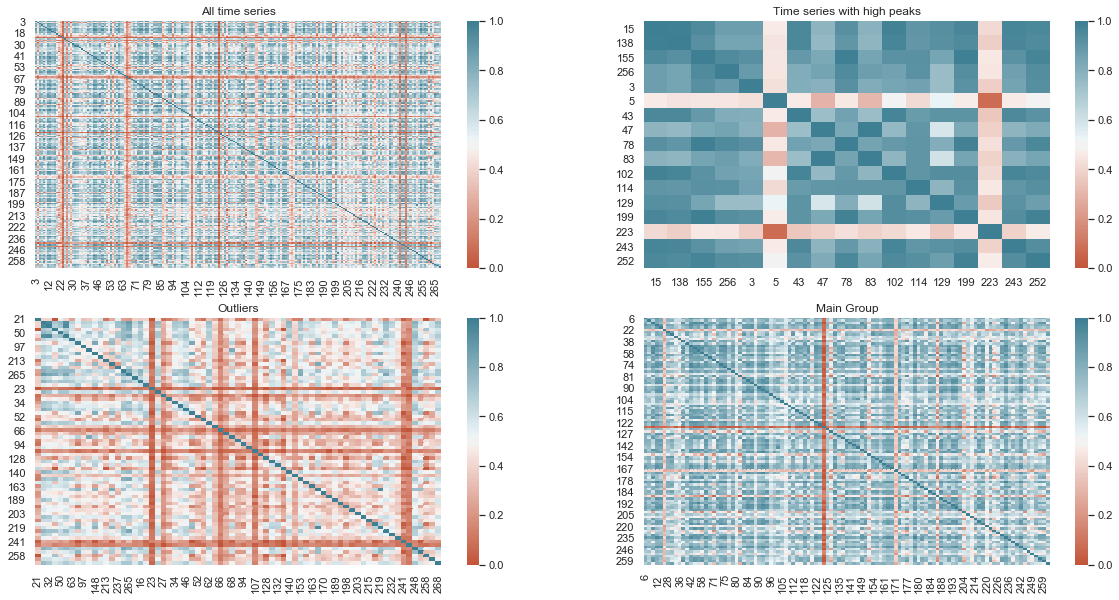

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20,10))

def create_corr_heatmap(dframe, x, y, title):
    ax = sns.heatmap(
    data=dframe.corr('pearson'), 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(20, 220, n=200),
    ax=axes[x][y]
    )
    ax.set(title=title)

create_corr_heatmap(df, 0, 0, "All time series")
create_corr_heatmap(df[groups['high']], 0, 1, "Time series with high peaks")
create_corr_heatmap(df[groups['outliers']], 1, 0, "Outliers")
create_corr_heatmap(df[groups['main']], 1, 1, "Main Group")
plt.show()

<h5>The correlation matrices show that there are 2 outliers in the high peak group, some correlating time series in the outlier group and one significant outlier in the main group. Resorting the groups for further analysis is neccesary.
We sort out all time series that have a low correlation in the upper 25% of the top correlating time series into the outlier set. Furthermore the outlier set will be split into really low correlating time series and a remaining group that needs further analysis.</h5>

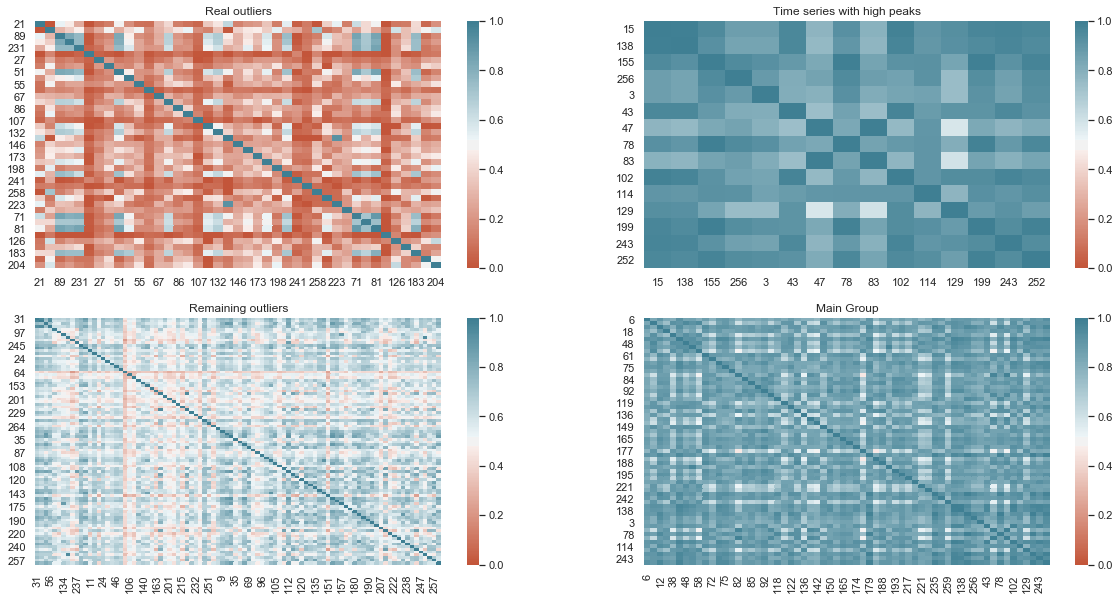

In [10]:
# initially putting all non correlating series into outliers
for group in groups:
    if(group != 'outliers'):
        corr = df[groups[group]].corr('pearson')
        for col in corr:
            #print(corr[col].sort_values()[int(0.80*len(corr[col])):len(corr[col])-1])
            if(corr[col].sort_values()[int(0.75*len(corr[col])):len(corr[col])-1].mean() < 0.85):
                groups[group].remove(col)
                groups['outliers'].append(col)

# creating a real outlier set based on current outliers
real_outliers = []
corr = df[groups['outliers']].corr('pearson')
for col in corr:
    if(corr[col].sort_values()[:int(0.1*len(corr[col]))].mean() < 0.15):
        groups['outliers'].remove(col)
        real_outliers.append(col)   

fig, axes = plt.subplots(2, 2, figsize=(20,10))

create_corr_heatmap(df[real_outliers], 0, 0, "Real outliers")
create_corr_heatmap(df[groups['high']], 0, 1, "Time series with high peaks")
create_corr_heatmap(df[groups['outliers']], 1, 0, "Remaining outliers")
create_corr_heatmap(df[(groups['main']+groups['high'])], 1, 1, "Main Group")
plt.show()

<h5>We try to cluster the main and high-peak series using a hierarchy which will be cut accordingly, if we find clusters.</h5>

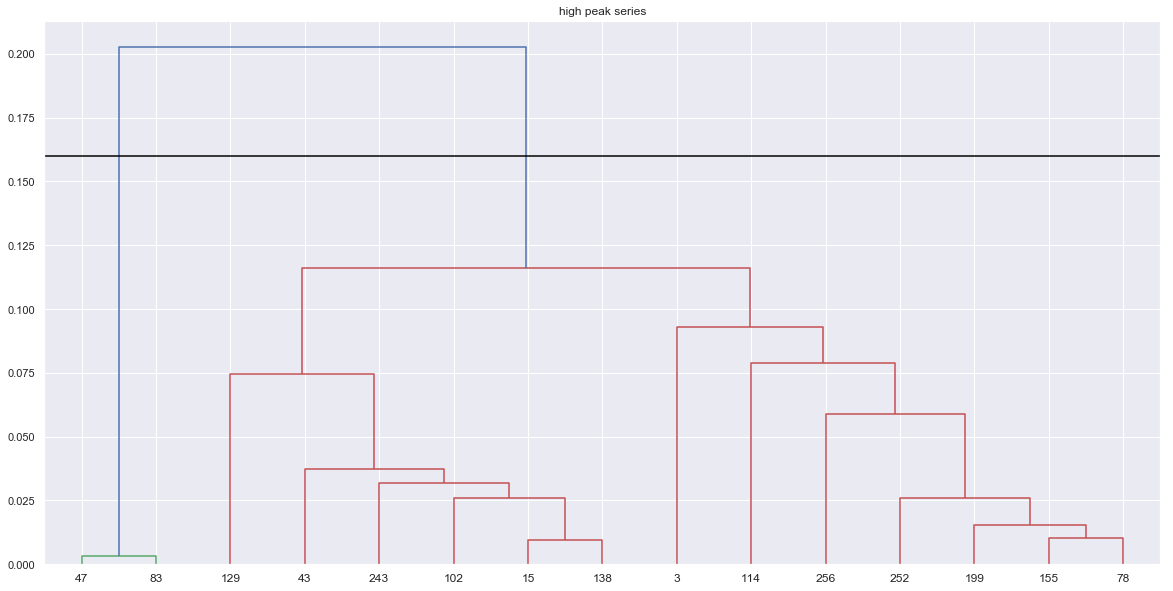

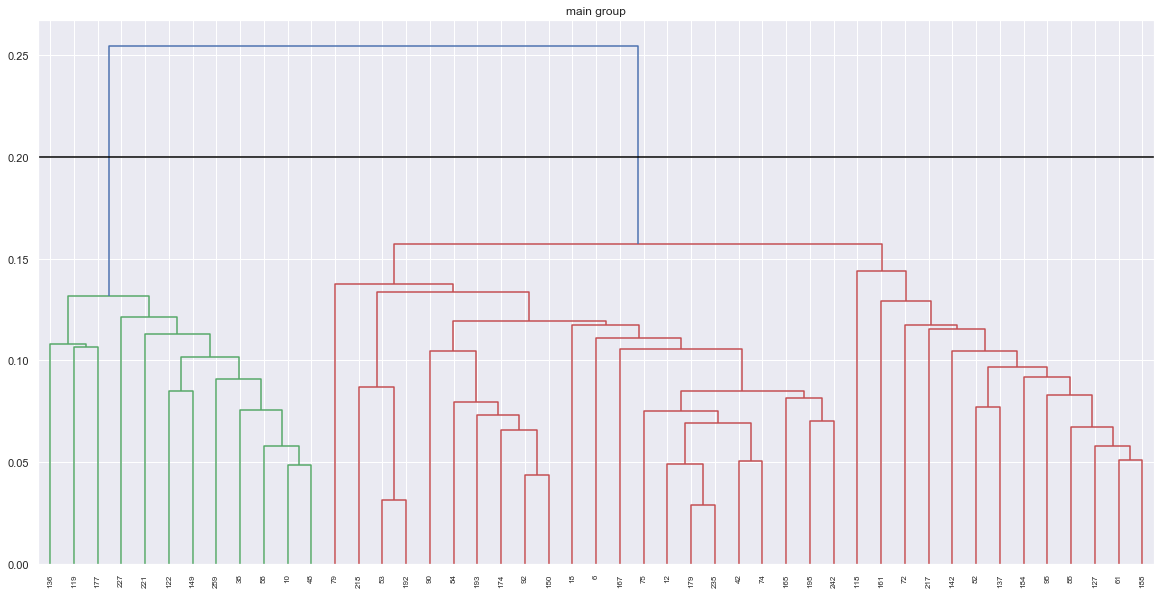

In [11]:
from scipy.cluster import hierarchy as hc

# High
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("high peak series")
dframe = df[groups['high']]
corr = 1-dframe.corr()
corr = corr.fillna(0.0)
corr_condensed = hc.distance.squareform(corr)
z_high = hc.linkage(corr_condensed, method='average')
plt.axhline(y=0.16, c='black')
dendrogram = hc.dendrogram(z_high, labels=corr.columns)
plt.show()

# Main
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('main group')
dframe = df[groups['main']]
corr = 1-dframe.corr()
corr = corr.fillna(0.0)
corr_condensed = hc.distance.squareform(corr)
z_main = hc.linkage(corr_condensed, method='average')
plt.axhline(y=0.2, c='black')
dendrogram = hc.dendrogram(z_main, labels=corr.columns)
plt.show()

<h5>Looking at the dendrograms of the high and the main group, we see we can cluster them in two groups by cutting at the plotted values.</h5>

In [12]:
# We cut both trees into two clusters each

def get_clusters(z, clusters, group):
    cut_tree = hc.cut_tree(z, n_clusters=clusters)
    clustered_series = []
    for cluster in range(0, clusters):
        bin_cols = []
        for idx, col in enumerate(group):
            if(cut_tree[idx][0] == cluster):
                bin_cols.append(col)
        clustered_series.append(bin_cols)
    return clustered_series

cluster_high = get_clusters(z_high, 2, groups['high'])
cluster_main =  get_clusters(z_main, 2, groups['main'])
print('high cluster 1:\n' + str(cluster_high[0]))
print('\nhigh cluster 2:\n' + str(cluster_high[1]))
print('\nmain cluster 1:\n' + str(cluster_main[0]))
print('\nmain cluster 2:\n' + str(cluster_main[1]))

high cluster 1:
[15, 138, 155, 256, 3, 43, 78, 102, 114, 129, 199, 243, 252]

high cluster 2:
[47, 83]

main cluster 1:
[6, 12, 18, 42, 53, 61, 72, 74, 75, 79, 82, 84, 85, 90, 92, 95, 118, 127, 137, 142, 150, 161, 165, 167, 174, 179, 184, 188, 192, 193, 195, 217, 218, 235, 242]

main cluster 2:
[10, 38, 48, 58, 119, 122, 136, 149, 177, 221, 227, 259]


<h5>Further manual analysis reveals that the first cluster of the high-peak series conforms well with the second cluster of the main group. The small cluster of the high-peak series conforms well with itself but with no other time series, so this will be put into the outlier set.</h5> 

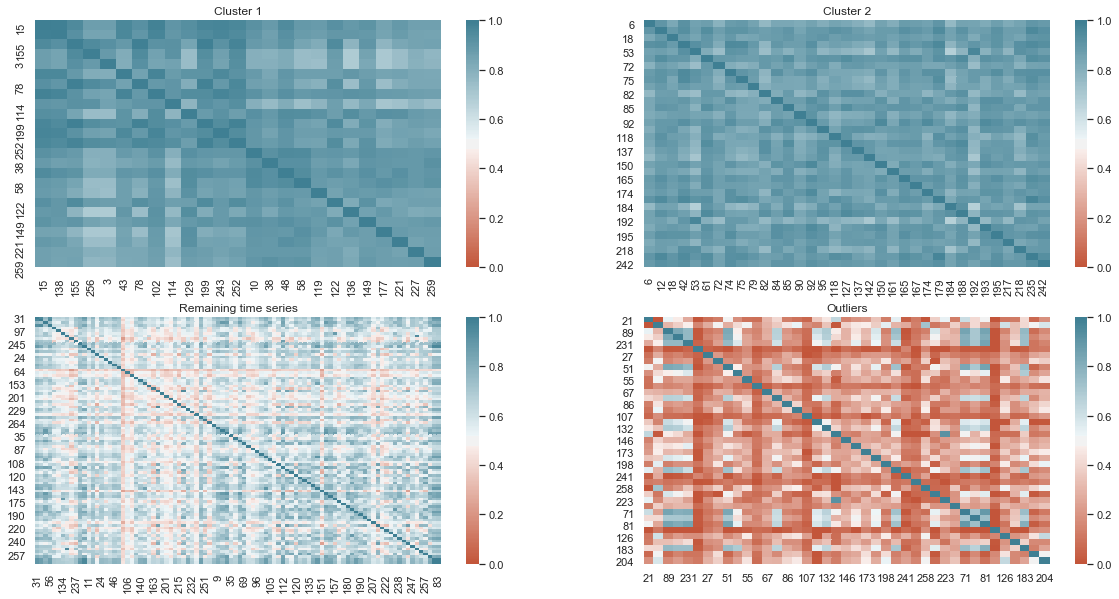

In [13]:
# New summary
groups_new = {
    'cluster1': (cluster_high[0] + cluster_main[1]),
    'cluster2': (cluster_main[0]),
    'remaining': (groups['outliers'] + cluster_high[1]),
    'outliers': real_outliers
}

fig, axes = plt.subplots(2, 2, figsize=(20,10))
create_corr_heatmap(df[groups_new['cluster1']], 0, 0, "Cluster 1")
create_corr_heatmap(df[groups_new['cluster2']], 0, 1, "Cluster 2")
create_corr_heatmap(df[groups_new['remaining']], 1, 0, "Remaining time series")
create_corr_heatmap(df[groups_new['outliers']], 1, 1, "Outliers")
plt.show()

<h5>We try a last clustering of the remaining time series using a z-transformation.</h5>

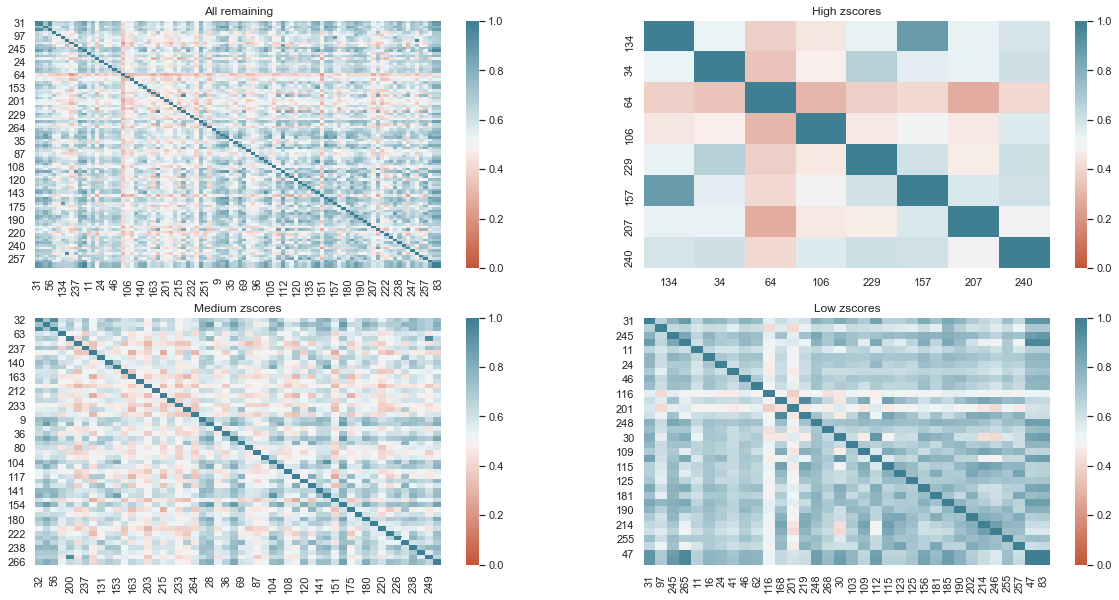

In [14]:
#z-score calc
cols = list(df.columns)
df_zscores = pd.DataFrame()
zlow = []
znormal = []
zhigh = []

def calc_zscore(dframe):
    zscores = pd.DataFrame()
    for col in dframe:
        zscores[col] = (df[col] - df[col].mean())/df[col].std()
    return zscores

df_rolled = rollmean_dframe(df[groups_new['remaining']],24)
zscores = calc_zscore(df_rolled)

high_z = []
medium_z = []
low_z = []

for col in zscores:
    max_score = np.absolute(zscores[col].max())
    min_score = np.absolute(zscores[col].min())
    diff = max_score - min_score
    if(diff > 5):  high_z.append(col)
    elif(diff > 2): medium_z.append(col)
    else: low_z.append(col)

fig, axes = plt.subplots(2, 2, figsize=(20,10))
create_corr_heatmap(df[groups_new['remaining']], 0, 0, "All remaining")
create_corr_heatmap(df[high_z], 0, 1, "High zscores")
create_corr_heatmap(df[medium_z], 1, 0, "Medium zscores")
create_corr_heatmap(df[low_z], 1, 1, "Low zscores")
plt.show()

<h5>Since the z-transformation did not yield good results other techniques should be considered to sort out the remaining wrong-clustered time series. Using DTW as a metric for clustering or statistical models that weren't applied in this analysis could yield better results. Furthermore it could have been a wrong start to sort out time series that take negative values since they could fit into some of the resulting clusters.</h5>

<h1>Question: Which time series could be grouped together as the most similar and how large are these groups?</h1>

<h2>Cluster 1</h2>

[15, 138, 155, 256, 3, 43, 78, 102, 114, 129, 199, 243, 252, 10, 38, 48, 58, 119, 122, 136, 149, 177, 221, 227, 259]

Length: 25


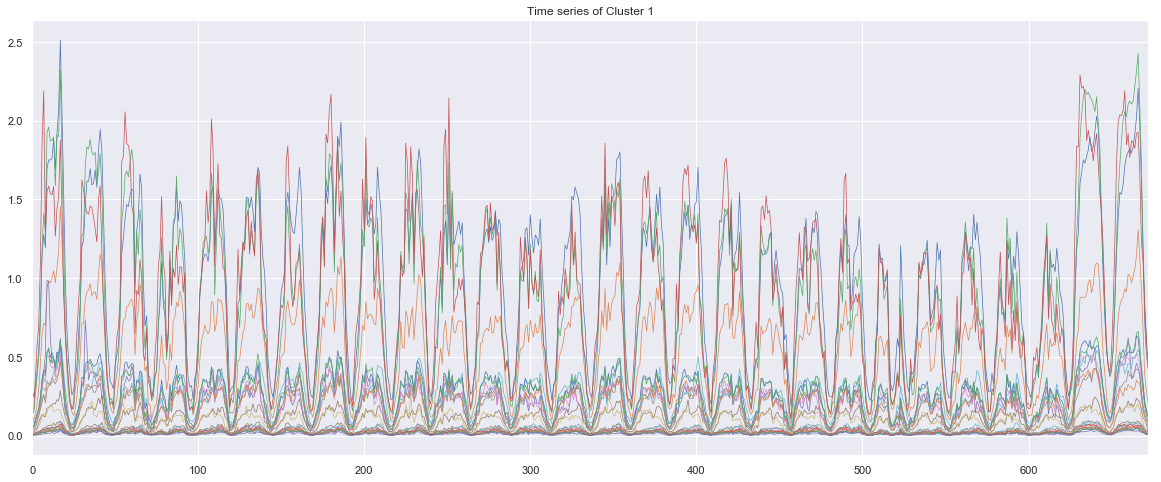

In [15]:
print(groups_new['cluster1'])
print('\nLength: ' + str(len(groups_new['cluster1'])))
df[groups_new['cluster1']].plot(linewidth=0.7, legend=None, figsize=(20,8), title="Time series of Cluster 1")

<h2>Cluster 2</h2>

[6, 12, 18, 42, 53, 61, 72, 74, 75, 79, 82, 84, 85, 90, 92, 95, 118, 127, 137, 142, 150, 161, 165, 167, 174, 179, 184, 188, 192, 193, 195, 217, 218, 235, 242]

Length: 35


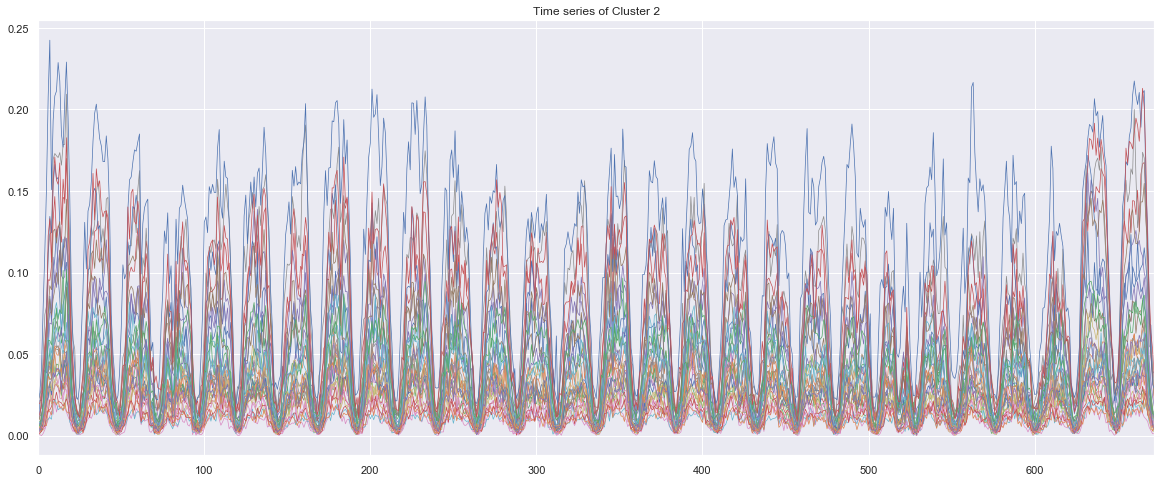

In [16]:
print(groups_new['cluster2'])
print('\nLength: ' + str(len(groups_new['cluster2'])))
df[groups_new['cluster2']].plot(linewidth=0.7, legend=None, figsize=(20,8), title="Time series of Cluster 2")

<h1>Question: How can I see the outliers in the given data set? ?</h1>

<h4>Outliers were filtered out using different techniques like sorting out time series with high distance to a large group of other time series as well as calculation of correlation matrices. Furthermore there are some outliers like zero-value time-series that can be filtered out easily in the stage of preprocessing.</h4>

<h1>Conclusion</h1>

<h4>Since the techniques used in this analysis weren't based on too much background knowledge, the results are not perfectly clustered. There some correlating time-series in the remaining group as well as in the outlier group which should /could be either fitted into the existing clusters or make up an own cluster.</h4>

<h2>Remaining time series</h2>

[31, 32, 50, 56, 63, 97, 134, 200, 213, 237, 245, 265, 11, 16, 19, 24, 34, 41, 46, 62, 64, 106, 116, 131, 140, 153, 159, 163, 168, 189, 201, 203, 212, 215, 219, 229, 232, 233, 248, 251, 264, 268, 9, 28, 30, 35, 36, 39, 69, 80, 87, 96, 103, 104, 105, 108, 109, 112, 115, 117, 120, 123, 125, 135, 141, 143, 151, 154, 156, 157, 175, 178, 180, 181, 185, 190, 202, 205, 207, 214, 220, 222, 226, 236, 238, 240, 246, 247, 249, 255, 257, 266, 47, 83]

Length: 94


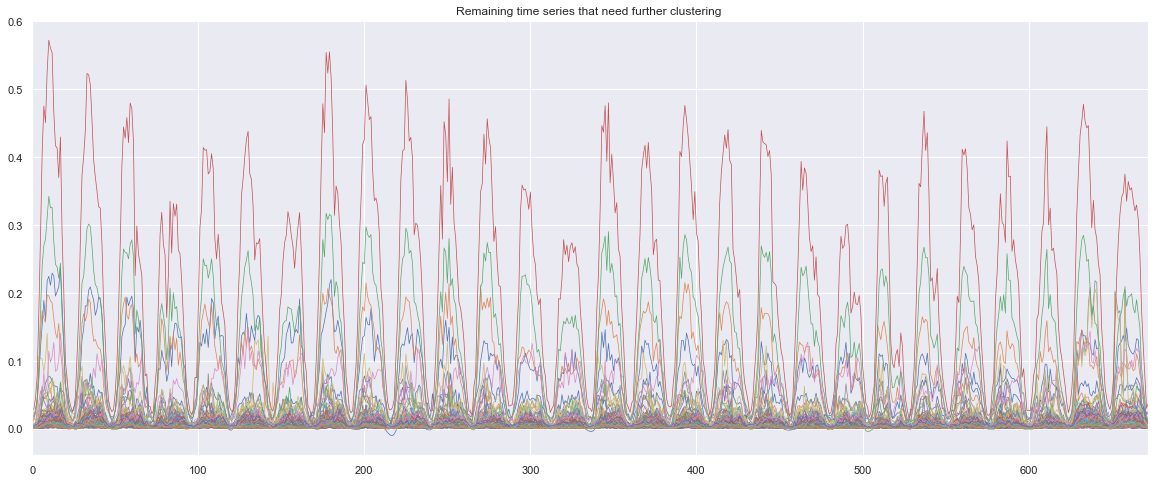

In [17]:
print(groups_new['remaining'])
print('\nLength: ' + str(len(groups_new['remaining'])))
df[groups_new['remaining']].plot(linewidth=0.7, legend=None, figsize=(20,8), title="Remaining time series that need further clustering ")

<h2>Outliers</h2>

[21, 37, 89, 148, 231, 23, 27, 29, 51, 52, 55, 66, 67, 68, 86, 94, 107, 128, 132, 139, 146, 170, 173, 191, 198, 216, 241, 244, 258, 5, 223, 22, 71, 76, 81, 124, 126, 171, 183, 187, 204]

Length: 41


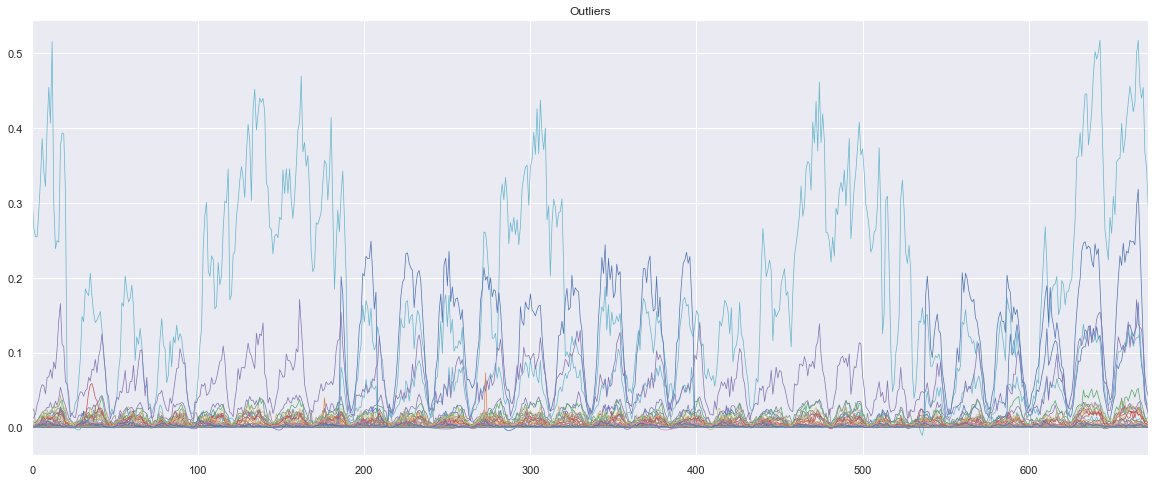

In [18]:
print(groups_new['outliers'])
print('\nLength: ' + str(len(groups_new['outliers'])))
df[groups_new['outliers']].plot(linewidth=0.7, legend=None, figsize=(20,8), title="Outliers")